# Predict extroverts vs introverts using classical ml ensemble models
This notebook uses a dataset with 20_000 entries and 7 features. It is a classical supervized classification problem. We follow the usual steps of exploring, engineering ,training an ensemble of models and evaluating the result.

## Table of Contents
- [Introduction](#introduction)
- [Data Exploration](#data-exploration)
- [Feature Engineering](#feature-engineering)
- [Model Training](#model-training)
- [Evaluations](#evaluations)
- [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
This notebook was written for <a href="https://www.kaggle.com/competitions/playground-series-s5e7">Predict the Introverts from the Extroverts</a> competion on Kaggle. It obtaiened a good score (0.972469) althouhg it was not engineered with neural networks in mind. As my first notebook on Kaggle, I focused on following the steps that are necessary for a succesful submission.

In [1]:
# Standard data manipulation and numerical computing
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model selection and evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, RandomizedSearchCV

# Metrics for model evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score, auc

# Machine learning models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import xgboost as xgb
from scipy.stats import uniform, randint
import lightgbm as lgb
import joblib
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

<a id="data-exploration"></a>
## Data exploration
Let's load data and check for patterns

In [2]:
path = './dataset/' # path for data files
models_path = path + 'models/' # path for saved models and saved preprocessing parameters

In [3]:
train = pd.read_csv(path + 'train.csv')
test  = pd.read_csv(path + 'test.csv')

In [4]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
train.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [4]:
# drop outliers ouside 1.5 * interquartile range
def detect_outliers(df,n,features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)

    return multiple_outliers

Otliers_to_drop = detect_outliers(train,2,['Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency'])

In [5]:
print(len(Otliers_to_drop))

0


we observe that there are no outliers

In [6]:
# concatenate train and test data into a single dataframe for better processing
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0)
dataset = dataset.drop('id', axis=1).reset_index(drop=True)
print(f"Shape of total dataset: {dataset.shape}\n")
print(dataset.tail())


Shape of total dataset: (24699, 8)

       Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
24694               3.0         No                      5.0            5.0   
24695               8.0        Yes                      2.0            1.0   
24696               2.0         No                      4.0            3.0   
24697               3.0         No                      4.0            4.0   
24698               NaN        Yes                      1.0            1.0   

      Drained_after_socializing  Friends_circle_size  Post_frequency  \
24694                        No                  9.0             6.0   
24695                       Yes                  0.0             0.0   
24696                        No                  9.0             7.0   
24697                        No                 11.0             9.0   
24698                       Yes                  1.0             0.0   

      Personality  
24694         NaN  
24695         NaN  
24

### distribution for numerical features

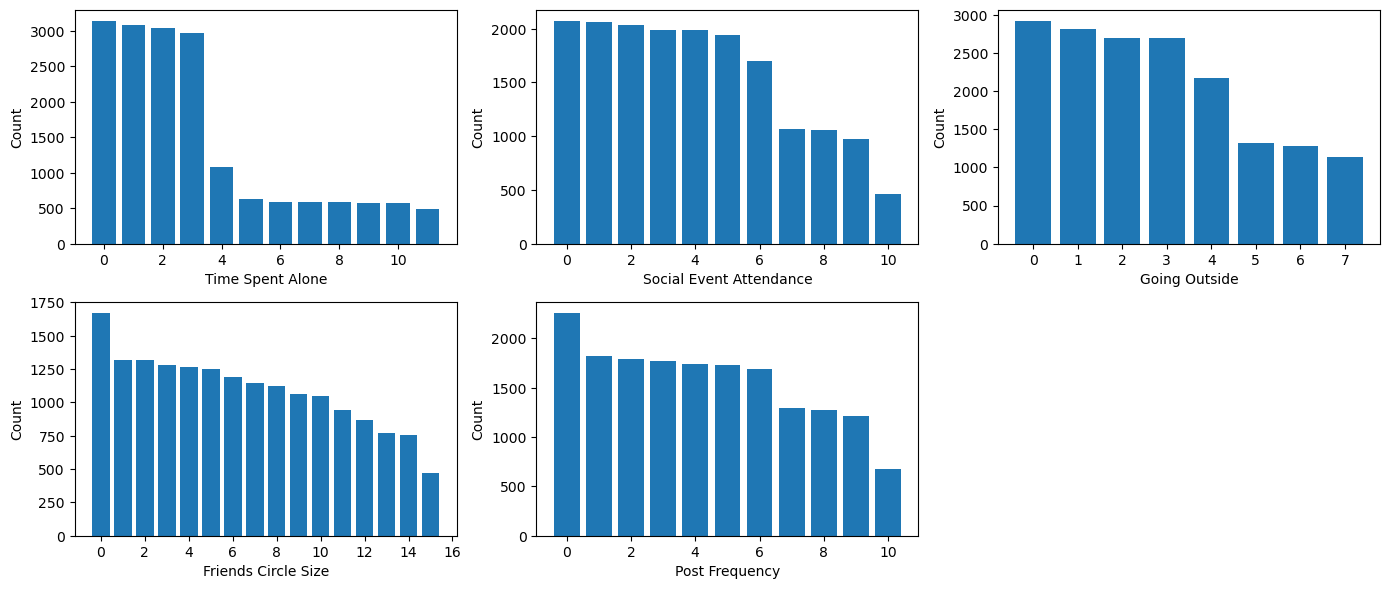

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))

# Bar plot for Time_spent_Alone
ax1.bar(np.arange(train['Time_spent_Alone'].max() + 1), train['Time_spent_Alone'].value_counts())
ax1.set_xlabel('Time Spent Alone')
ax1.set_ylabel('Count')

# Bar plot for Social_event_attendance
ax2.bar(np.arange(train['Social_event_attendance'].max() + 1), train['Social_event_attendance'].value_counts())
ax2.set_xlabel('Social Event Attendance')
ax2.set_ylabel('Count')

# Bar plot for Going_outside
ax3.bar(np.arange(train['Going_outside'].max() + 1), train['Going_outside'].value_counts())
ax3.set_xlabel('Going Outside')
ax3.set_ylabel('Count')

# Bar plot for Friends_circle_size
ax4.bar(np.arange(train['Friends_circle_size'].max() + 1), train['Friends_circle_size'].value_counts())
ax4.set_xlabel('Friends Circle Size')
ax4.set_ylabel('Count')

# Bar plot for Post_frequency
ax5.bar(np.arange(train['Post_frequency'].max() + 1), train['Post_frequency'].value_counts())
ax5.set_xlabel('Post Frequency')
ax5.set_ylabel('Count')

# Hide the last subplot
ax6.set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

### distribution for labels

In [10]:
counts = train['Personality'].value_counts()
print(counts)

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64


<Axes: xlabel='Personality', ylabel='count'>

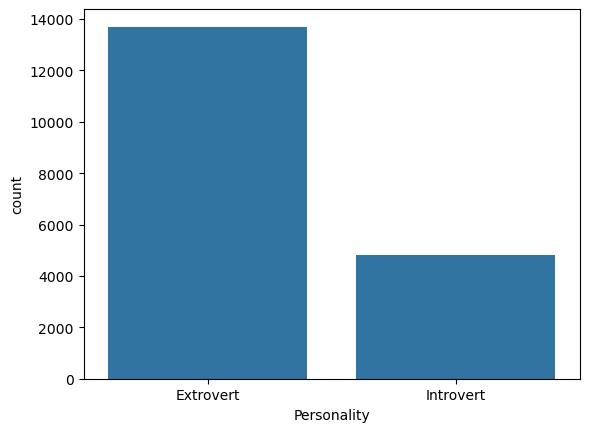

In [7]:
sns.countplot(data=train, x='Personality')

### We have a mildly unbalanced dataset as we see in the distribution of label, but it will not be necessary to do any data transformation as we will see in the performance metrics

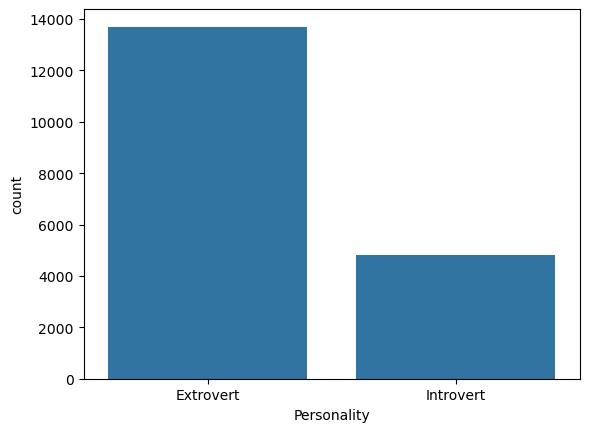

In [8]:
countplot = sns.countplot(data=train, x='Personality')
fig = countplot.get_figure()
fig.savefig("extro_intro_proportion.png")


In [9]:
train['Personality'] = train['Personality'].map({'Extrovert':1, 'Introvert':0}) # map labels

### let's build a correlation matrix
I did not include the binary categorical features, because they need preprocessing (1-hot-encoding)

I will do that in the feature engineering section

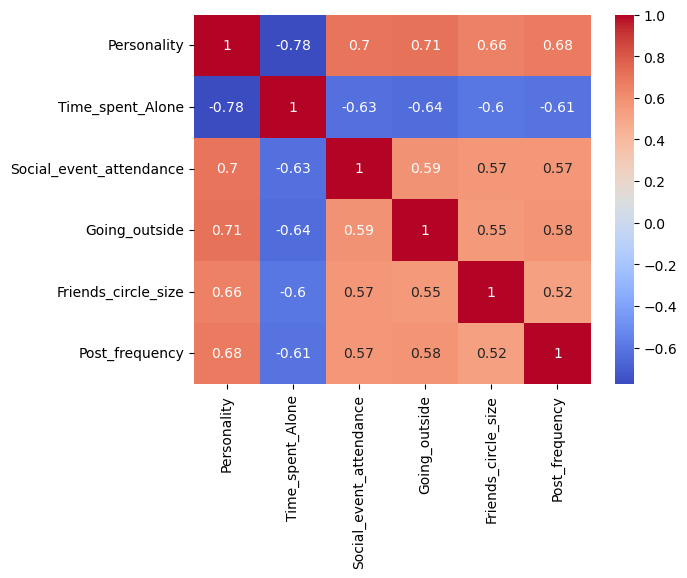

In [13]:
g = sns.heatmap(train[['Personality','Time_spent_Alone','Social_event_attendance','Going_outside',
                      'Friends_circle_size','Post_frequency']].corr(), cmap='coolwarm',annot=True)

### we observe that all numerical features are correlated with Personality

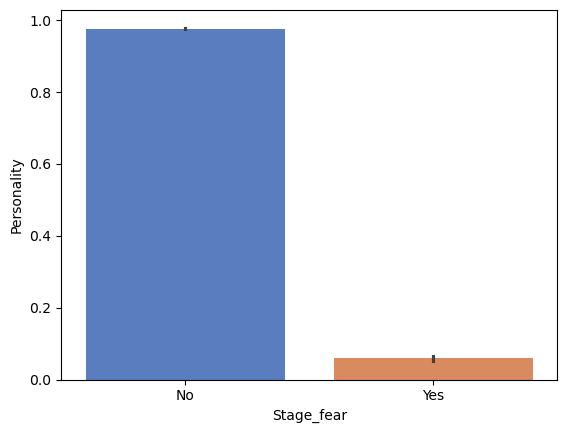

In [14]:
g = sns.barplot(data=train, x="Stage_fear", y="Personality", palette="muted")

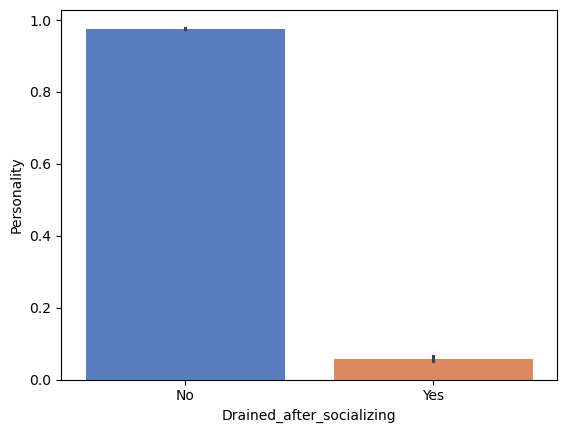

In [15]:
g = sns.barplot(data=train, x="Drained_after_socializing", y="Personality", palette="muted")

### the categorical features are also highly correlated with Personality

<a id="feature-engineering"></a>
## Feature engineering

let's fill the missing numbers

In [10]:
dataset.fillna(np.nan) # consistent values
print(dataset.isnull().sum())

Time_spent_Alone             1615
Stage_fear                   2491
Social_event_attendance      1577
Going_outside                1932
Drained_after_socializing    1581
Friends_circle_size          1404
Post_frequency               1672
Personality                  6175
dtype: int64


fill the numerical features

In [11]:
imputer = SimpleImputer(strategy="median")

In [12]:
y_train = train['Personality']
X_train_num = train.select_dtypes(include=[np.number]).drop(['id','Personality'], axis=1, errors='ignore') # numerical features only
dataset_num = dataset[X_train_num.columns]

In [13]:
imputer.fit(X_train_num) # only on train data

SimpleImputer(strategy='median')

### here I save the imputer for beeing necessary when I deploy the code in production

In [14]:
file_path = models_path + 'imputer.pkl'
if os.path.exists(file_path):
    print(f"Imputer already saved at {file_path}")
else:
    joblib.dump(imputer, file_path)
    print(f"Imputer saved at {file_path}")


Imputer already saved at ./dataset/models/imputer.pkl


In [15]:
X = imputer.transform(dataset_num) # input on all data: train + test

In [16]:
dataset_num_imputed = pd.DataFrame(X, columns=dataset_num.columns)
train_num_imputed = dataset_num_imputed[:len(train)] # used later for training a scaler
len(train_num_imputed)

18524

In [17]:
dataset_num_imputed.isna().sum()

Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64

### all numerical feature values have been filled
now le't fill the categorical features

In [18]:
X_train_cat = train.select_dtypes(include=[object]).drop(['Personality'], axis=1, errors='ignore')
dataset_cat = dataset[X_train_cat.columns]

In [19]:
dataset_cat.head() # verifying we selected the correct features

,Stage_fear,Drained_after_socializing
0,No,No
1,No,No
2,Yes,NaN
3,No,No
4,No,No


In [20]:
print(X_train_cat.isna().sum())
print(dataset_cat.isna().sum())

Stage_fear                   1893
Drained_after_socializing    1149
dtype: int64
Stage_fear                   2491
Drained_after_socializing    1581
dtype: int64


In [21]:
imputer_cat = SimpleImputer(strategy="most_frequent")

In [22]:
imputer_cat.fit(X_train_cat) # only on train data

SimpleImputer(strategy='most_frequent')

In [23]:
file_path = models_path + 'imputer_cat.pkl' # imputer needed in production
if os.path.exists(file_path):
    print(f"Imputer already saved at {file_path}")
else:
    joblib.dump(imputer_cat, file_path)
    print(f"Imputer saved at {file_path}")

Imputer already saved at ./dataset/models/imputer_cat.pkl


In [24]:
X_cat = imputer_cat.transform(dataset_cat) # on all data

In [25]:
dataset_cat_imputed = pd.DataFrame(X_cat, columns=dataset_cat.columns)

In [26]:
dataset_cat_imputed.head()

,Stage_fear,Drained_after_socializing
0,No,No
1,No,No
2,Yes,No
3,No,No
4,No,No


In [27]:
dataset_cat_imputed.isna().sum()

Stage_fear                   0
Drained_after_socializing    0
dtype: int64

### all categorical features have been filled
let's one-hot-encode the binary categorical features

In [28]:
cat_encoder = OneHotEncoder()
dataset_cat_1hot = cat_encoder.fit_transform(dataset_cat_imputed)

In [29]:
file_path = models_path + '1hot_encoder.pkl' # needed in production
if os.path.exists(file_path):
    print(f"1HotEncoder already saved at {file_path}")
else:
    joblib.dump(cat_encoder, file_path)
    print(f"1HotEncoder saved at {file_path}")

1HotEncoder already saved at ./dataset/models/1hot_encoder.pkl


In [30]:
#build dataframe from the sparse matrix, with new column names generated based on column_name__value
dataset_cat_1hot = pd.DataFrame(dataset_cat_1hot.toarray(),columns=cat_encoder.get_feature_names_out())

In [31]:
dataset_cat_1hot.head()

,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0


### now let's standardize features by removing the mean and scaling to unit variance
this is necessary for some models we use later

In [32]:
scaler = StandardScaler()

In [33]:
scaler.fit(train_num_imputed) # only on train data

StandardScaler()

In [34]:
file_path = models_path + 'scaler.pkl' # needed in production
if os.path.exists(file_path):
    print(f"Scaler already saved at {file_path}")
else:
    joblib.dump(scaler, file_path)
    print(f"1HotEncoder saved at {file_path}")

Scaler already saved at ./dataset/models/scaler.pkl


In [35]:
X_fit = scaler.transform(dataset_num_imputed) # on all data

In [36]:
dataset_num_std_scaled = pd.DataFrame(X_fit, columns=dataset_num_imputed.columns)

In [37]:
dataset_num_std_scaled.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
0,-1.049913,0.282102,-0.020620,1.707463,0.006002
1,-0.707327,0.657346,-0.525859,0.488383,1.085490
2,1.005601,-1.594120,-2.041578,-1.218331,-1.793144
3,-0.022156,0.657346,-0.525859,0.732199,0.006002
4,-0.707327,-0.468387,-0.020620,1.219831,0.006002


In [38]:
dataset_final = pd.DataFrame(pd.merge(dataset_num_std_scaled,dataset_cat_1hot, left_index=True, right_index=True)) # for better processing

In [39]:
print(dataset_final.shape)

(24699, 9)


In [40]:
y_train

0        1
1        1
2        0
3        1
4        1
        ..
18519    1
18520    1
18521    0
18522    0
18523    1
Name: Personality, Length: 18524, dtype: int64

### split dataset in train, test and labels

In [41]:
X_train = dataset_final[:len(train)]
X_test = dataset_final[len(train):]
Y_train = y_train

<a id="model-training"></a>
## Model training
I use an ensemble learning with stacking, based on classical ml algorithms
Although the competition admitted neural networks, my entry is with this structure because it is my first submission to Kaggle

### using Stratified KFold because the label has a slight imbalance

In [42]:
kfold = StratifiedKFold(n_splits=5) # between 5 and 10 is generally used; I chose 5 for training time performance

### here I test 10 ml algorithms, eventually picking just top 3

In [43]:
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

# Corrected barplot call
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=cv_res, palette="Set3", orient="h",
                order=cv_res.sort_values("CrossValMeans", ascending=False)["Algorithm"])
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

KeyboardInterrupt: 

In [50]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.968528,0.003444,SVC
1,0.927284,0.003950,DecisionTree
2,0.942993,0.005428,AdaBoost
3,0.963669,0.004718,RandomForest
4,0.960322,0.003902,ExtraTrees
5,0.968474,0.003592,GradientBoosting
6,0.968852,0.003638,MultipleLayerPerceptron
7,0.968366,0.003256,KNeighboors
8,0.968636,0.003005,LogisticRegression
9,0.967934,0.002897,LinearDiscriminantAnalysis


### Picked Support Vector Classification, MultipleLayerPerceptron and LogisticRegression
I use 2 supplemental algorithms: XGBoost and LightGBM , because having a more diverse selection improves the overall score

In [50]:
### SVC classifier
file_path = models_path + 'rsSVMC.pkl'

if os.path.exists(file_path):
    rsSVMC = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    
    SVMC = SVC(probability=False) #probability=True takes more time to train; 
                                    #will see if I enable it after reading the performance scores

    # Define parameter distributions for RandomizedSearchCV
    # Use uniform distribution for continuous parameters like gamma and C
    svc_param_distributions = {'kernel': ['rbf'],
                            'gamma': uniform(0.001, 1), # Random float between 0.001 and 1
                            'C': uniform(1, 1000)} # Random float between 1 and 1000

    # Use RandomizedSearchCV instead of GridSearchCV
    rsSVMC = RandomizedSearchCV(SVMC, param_distributions=svc_param_distributions,
                                n_iter=10, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsSVMC.fit(X_train,Y_train)

    SVMC_best = rsSVMC.best_estimator_

    # Best score
    rsSVMC.best_score_

    joblib.dump(rsSVMC,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsSVMC.pkl


In [51]:
SVMC_best=rsSVMC.best_estimator_
SVMC_best

SVC(C=np.float64(157.01864044243652), gamma=np.float64(0.15699452033620265))

In [52]:
### MLP classifier
file_path = models_path + 'rsMLP.pkl'

if os.path.exists(file_path):
    rsMLP = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    MLP = MLPClassifier()

    # Define parameter distributions for RandomizedSearchCV
    mlp_param_distributions = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 
        'activation': ['relu'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive'], 
        'learning_rate_init': uniform(0.001, 0.01),
        'alpha': uniform(0.0001, 0.001), 
        'batch_size': [32, 64],
        'max_iter': randint(200, 400) 
    }

    # Use RandomizedSearchCV instead of GridSearchCV
    rsMLP = RandomizedSearchCV(MLP, param_distributions=mlp_param_distributions, n_iter=20, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsMLP.fit(X_train,Y_train)

    MLP_best = rsMLP.best_estimator_

    # Best score
    rsMLP.best_score_

    joblib.dump(rsMLP,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsMLP.pkl


In [53]:
MLP_best=rsMLP.best_estimator_
MLP_best

MLPClassifier(alpha=np.float64(0.0003327713404303042), batch_size=64,
              hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=np.float64(0.0029967378215835973),
              max_iter=254, solver='sgd')

In [54]:
# Linear regression
file_path = models_path + 'rsLR.pkl'

if os.path.exists(file_path):
    rsLR = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    LR = LogisticRegression()

    # To handle the penalty/solver compatibility with RandomizedSearchCV,
    # we can either manually specify valid combinations or use a solver that supports
    # the desired penalties. 'saga' supports 'l1', 'l2', and 'elasticnet'.
    # 'liblinear' supports 'l1' and 'l2'.

    # Let's define separate distributions for solvers to ensure compatibility
    lr_param_distributions = [
        # Combinations for 'liblinear' solver
        {'penalty': ['l1', 'l2'],
        'C': uniform(0.01, 10),
        'solver': ['liblinear']},
        # Combinations for 'saga' solver
        {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': uniform(0.01, 10),
        'solver': ['saga'],
        'l1_ratio': uniform(0, 1)} # l1_ratio is only used with elasticnet
    ]


    # Use RandomizedSearchCV instead of GridSearchCV
    # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
    rsLR = RandomizedSearchCV(LR, param_distributions=lr_param_distributions, n_iter=40, cv=kfold,
                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsLR.fit(X_train,Y_train)

    LR_best = rsLR.best_estimator_

    # Best score
    rsLR.best_score_

    joblib.dump(rsLR,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsLR.pkl


In [55]:
LR_best =  rsLR.best_estimator_
LR_best

LogisticRegression(C=np.float64(0.08066305219717405),
                   l1_ratio=np.float64(0.023062425041415757),
                   penalty='elasticnet', solver='saga')

In [56]:
### xgboost 
file_path = models_path + 'rsXGB.pkl' 

if os.path.exists(file_path):
    rsXGB = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")
    XGB = xgb.XGBClassifier(objective='binary:logistic', # Binary classification
                            eval_metric='logloss',       # Evaluation metric
                            # use_label_encoder=False,     # Deprecated, set to False
                            random_state=42)

    # Define parameter distributions for RandomizedSearchCV for XGBoost
    xgb_param_distributions = {
        'n_estimators': randint(100, 1000),  # Number of boosting rounds
        'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
        'max_depth': randint(3, 10),         # Maximum depth of a tree
        'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
        'gamma': uniform(0, 0.5),            # Minimum loss reduction required to make a further partition
        'subsample': uniform(0.6, 0.4),      # Subsample ratio of the training instances
        'colsample_bytree': uniform(0.6, 0.4),# Subsample ratio of columns when constructing each tree
        'reg_alpha': uniform(0, 1),          # L1 regularization term on weights
        'reg_lambda': uniform(0, 1)         # L2 regularization term on weights
        }


    # Use RandomizedSearchCV instead of GridSearchCV
    # n_iter: Number of parameter settings that are sampled. Increase for a more exhaustive search.
    rsXGB = RandomizedSearchCV(XGB, param_distributions=xgb_param_distributions, n_iter=40, cv=kfold,
                            scoring="accuracy", n_jobs=-1, verbose=1, random_state=42)

    rsXGB.fit(X_train,Y_train)

    XGB_best = rsXGB.best_estimator_

    # Best score
    rsXGB.best_score_

    joblib.dump(rsXGB,file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsXGB.pkl


In [57]:
XGB_best =  rsXGB.best_estimator_
XGB_best


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9314950036607718), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.17837666334679464), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.09428035290621423), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, ...)

In [58]:
# LightGBM
file_path = models_path + 'rsLGBM.pkl'

if os.path.exists(file_path):
    rsLGBM = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")

    lgbm_param_distributions = {
        'n_estimators': randint(200, 1000),  # Number of boosting iterations (trees) to be built, ranging from 200 to 1000
        'learning_rate': uniform(0.001, 0.1),  # Step size for each boosting step, sampled from 0.001 to 0.101
        'num_leaves': randint(31, 200),  # Maximum number of leaves in one tree, controlling model complexity, ranging from 31 to 200
        'max_depth': randint(5, 20),  # Maximum depth of each tree, limiting tree growth, ranging from 5 to 20
        'min_child_samples': randint(5, 50),  # Minimum number of samples required in a leaf node, ranging from 5 to 50
        'subsample': uniform(0.6, 0.4),  # Fraction of samples used for training each tree, sampled from 0.6 to 1.0
        'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for each tree, sampled from 0.6 to 1.0
        'reg_alpha': uniform(0, 1),  # L1 regularization term on weights, sampled from 0 to 1
        'reg_lambda': uniform(0, 1),  # L2 regularization term on weights, sampled from 0 to 1
        'min_split_gain': uniform(0, 0.1)  # Minimum gain required for a split, sampled from 0 to 0.1
    }
    
    # Initialize LightGBM Classifier
    LGBM = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', 
                              random_state=42, is_unbalance=True, verbose=-1)

    # Use RandomizedSearchCV
    rsLGBM = RandomizedSearchCV(
        estimator=LGBM, 
        param_distributions=lgbm_param_distributions, 
        n_iter=2, 
        cv=kfold,
        scoring="accuracy", 
        n_jobs=-1, 
        verbose=1, 
        random_state=42
    )

    # Fit the model with early stopping
    rsLGBM.fit(
        X_train, 
        Y_train,
        eval_set=[(X_train, Y_train)], 
        eval_metric='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    # Get the best estimator
    LGBM_best = rsLGBM.best_estimator_

    # Print best parameters and score
    print("Best Parameters:", rsLGBM.best_params_)
    print("Best Cross-Validation Accuracy:", rsLGBM.best_score_)

    # Save the model
    joblib.dump(rsLGBM, file_path)
    if os.path.exists(file_path):
        print(f"Successfully wrote {file_path}")
    else:
        print(f"Error: Could not save model at {file_path}")

Successfully loaded ./dataset/models/rsLGBM.pkl


In [59]:
LGBM_best = rsLGBM.best_estimator_
LGBM_best

LGBMClassifier(colsample_bytree=np.float64(0.749816047538945),
               is_unbalance=True, learning_rate=np.float64(0.09607143064099162),
               max_depth=15, metric='binary_logloss', min_child_samples=12,
               min_split_gain=np.float64(0.05986584841970366), n_estimators=814,
               num_leaves=152, objective='binary', random_state=42,
               reg_alpha=np.float64(0.15599452033620265),
               reg_lambda=np.float64(0.05808361216819946),
               subsample=np.float64(0.9464704583099741), verbose=-1)

### Plot a correlation matrix of the predictions of trained models
There is too much correlation, in the detriment of diversity. I chose to use a StackingClassifier with the last layer a Logistic Regresion instead of a voter

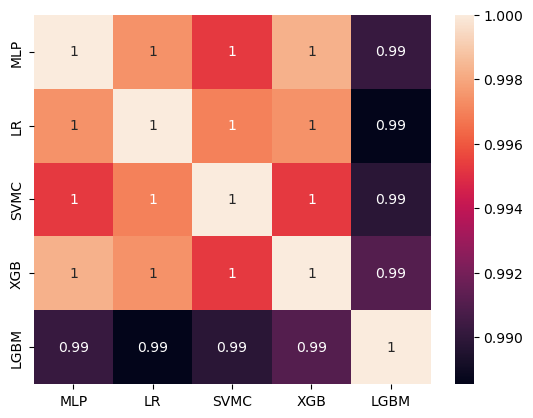

In [60]:
test_Extrovert_MLP = pd.Series(MLP_best.predict(X_test), name="MLP")
test_Extrovert_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Extrovert_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVMC")
test_Extrovert_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")
test_Extrovert_LGBM = pd.Series(LGBM_best.predict(X_test), name="LGBM")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Extrovert_MLP,test_Extrovert_LR,test_Extrovert_SVMC,test_Extrovert_XGB, test_Extrovert_LGBM],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)
# mabe too much similariy

In [61]:
fig = g.get_figure()
fig.savefig("corr_matrix.png")

### train the Ensemble Model

In [62]:
file_path = models_path + 'ensemble.pkl'

if os.path.exists(file_path):
    stackingC = joblib.load(file_path)
    print(f"Successfully loaded {file_path}")
else:
    print(f"Model not found at {file_path}, computing algorithm")

    #implement stacking
    from sklearn.ensemble import StackingClassifier
    stackingC = StackingClassifier(estimators=[('mlp', MLP_best), ('lr', LR_best),
    ('svc', SVMC_best), ('xgb', XGB_best), ('lgbm',LGBM_best)],  final_estimator=LogisticRegression(), n_jobs=-1)

    stackingC = stackingC.fit(X_train, Y_train)

    # Save the trained stacking classifier
    file_path = models_path + 'ensemble.pkl'
    joblib.dump(stackingC, file_path)

    # Verify that the model has been saved
    if os.path.exists(file_path):
        print(f"Successfully saved the ensemble model to {file_path}")
    else:
        print(f"Error: Could not save the ensemble model at {file_path}")

Successfully loaded ./dataset/models/ensemble.pkl


In [65]:
stackingC

StackingClassifier(estimators=[('mlp',
                                MLPClassifier(alpha=np.float64(0.0003327713404303042),
                                              batch_size=64,
                                              hidden_layer_sizes=(50, 50),
                                              learning_rate='adaptive',
                                              learning_rate_init=np.float64(0.0029967378215835973),
                                              max_iter=254, solver='sgd')),
                               ('lr',
                                LogisticRegression(C=np.float64(0.08066305219717405),
                                                   l1_ratio=np.float64(0.023062425041415757),
                                                   penalty='e...
                                               max_depth=15,
                                               metric='binary_logloss',
                                               min_child_samples=12,
                                               min_split_gain=np.float64(0.05986584841970366),
                                               n_estimators=814, num_leaves=152,
                                               objective='binary',
                                               random_state=42,
                                               reg_alpha=np.float64(0.15599452033620265),
                                               reg_lambda=np.float64(0.05808361216819946),
                                               subsample=np.float64(0.9464704583099741),
                                               verbose=-1))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

<a id="evaluations"></a>
## Evaluations

In [63]:
# Get cross-validated predictions for the stacking classifier
Y_train_pred_stacking = cross_val_predict(stackingC, X_train, Y_train, cv=kfold)

# Calculate metrics for the stacking classifier
accuracy_stacking = accuracy_score(Y_train, Y_train_pred_stacking)
precision_stacking = precision_score(Y_train, Y_train_pred_stacking, pos_label=1)
recall_stacking = recall_score(Y_train, Y_train_pred_stacking, pos_label=1)
f1_stacking = f1_score(Y_train, Y_train_pred_stacking, pos_label=1)
conf_matrix_stacking = confusion_matrix(Y_train, Y_train_pred_stacking)


print("Metrics for Stacking Classifier:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"Precision: {precision_stacking:.4f}")
print(f"Recall: {recall_stacking:.4f}")
print(f"F1-score: {f1_stacking:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_stacking)

Metrics for Stacking Classifier:
Accuracy: 0.9686
Precision: 0.9773
Recall: 0.9804
F1-score: 0.9788

Confusion Matrix:
[[ 4513   312]
 [  269 13430]]


#### Plot metrics

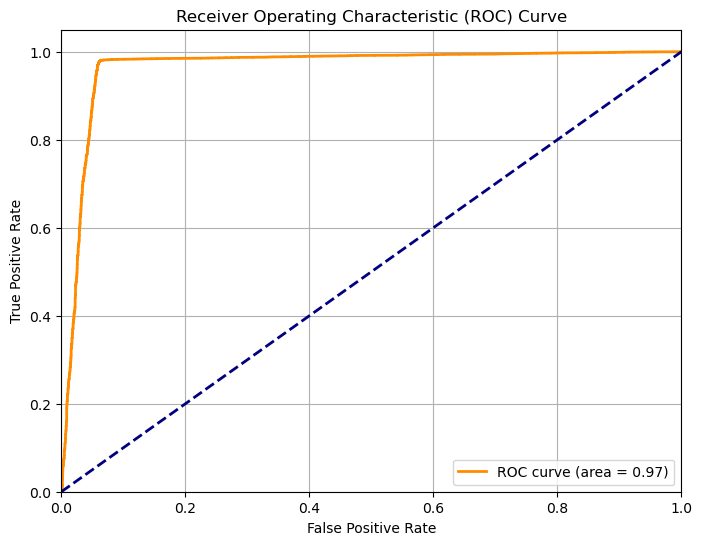

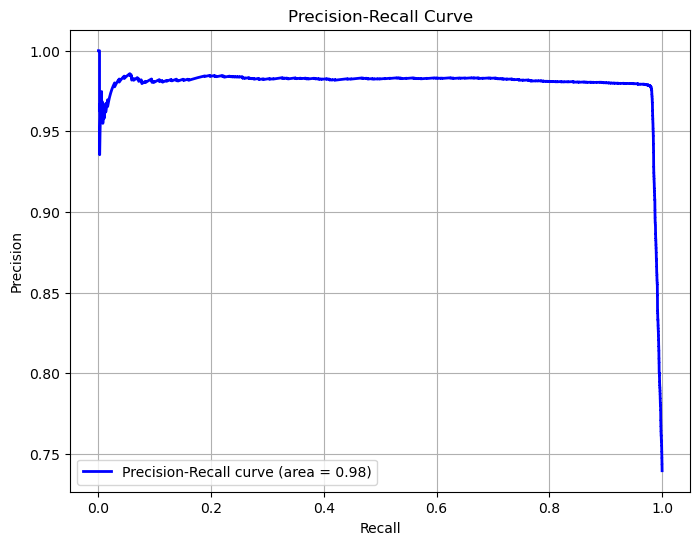

In [66]:
# Get cross-validated probability predictions for the positive class (Extrovert)
Y_scores_stacking = cross_val_predict(stackingC, X_train, Y_train, cv=kfold, method="predict_proba")[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(Y_train, Y_scores_stacking)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(Y_train, Y_scores_stacking)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### Predictions

In [68]:
test_Extrovert = pd.Series(stackingC.predict(X_test), name="Personality")

test_Extrovert

0       1
1       0
2       1
3       1
4       0
       ..
6170    1
6171    0
6172    1
6173    1
6174    0
Name: Personality, Length: 6175, dtype: int64

### process data and make submission

In [69]:
X_test = X_test[[]]
# test_Extrovert.values
X_test = X_test.assign(Personality=test_Extrovert.values)
X_test.Personality.replace({0:'Introvert',1:'Extrovert'},inplace=True)

In [70]:
X_test.index.name = 'id'
X_test

,Personality
id,
18524,Extrovert
18525,Introvert
18526,Extrovert
18527,Extrovert
18528,Introvert
...,...
24694,Extrovert
24695,Introvert
24696,Extrovert


In [71]:
X_test.to_csv(path + 'submission.csv')

## Conclusion

The ensemble model, combining five classical machine learning algorithms, achieved a strong accuracy score of 0.9687 on the local test set, which consisted of 20,000 entries across seven features. The model further demonstrated its robustness by attaining a public score of 0.9733 on the Kaggle competition leaderboard. While the primary focus of this project was to adhere to the submission process rather than optimizing for a top leaderboard position, the results indicate a reliable and effective model.

Moving forward, the next step is to deploy the model into a production environment. This will involve integrating the model into a real-world application, with a simple web form, dynamic output and a CI/CD pipeline. Future work could also explore feature engineering or hyperparameter tuning.